# Robust Loss Functions for Training on Noisy Labels

## **Author**
Jessica Ding, j68ding@uwaterloo.ca

## **Abstract**
When training image classifiers on image data, we typically assume that our data is labelled perfectly. This is not always the case. There are many problems where we cannot guarantee perfect labelling of our dataset due to human error. With image classification, there are instances where the class is a bit ambiguious such when distinguishing between cats and dogs. To train models for these We need robust training strategies that can handle data with imperfect labelling.

We will explore the approach used in [2018 paper by Zhilu Zhang, Mert R. Sabuncu](https://arxiv.org/pdf/1805.07836) of using Generalized Cross Entropy. We will also compare this to another approach used for noisy label by [Yisen Wang, Xingjun Ma, Zaiyi Chen, et. al. in their 2019 paper](https://arxiv.org/pdf/1908.06112)


# **Motivation**
Oftentimes we cannot assume that our dataset is labelled completely accurately. We can expect a certain level of noise in our label due to human error or overall ambiguity of classification. Under these circumstance, we want to design our deep learning architecture to be robust against noisy labels.

## **Disadvantage of Cross Entropy Loss**
$$CE(p,y) = -\sum_{i=1}^{C} y_i \log(p_i) = -\log (p_y)$$
Cross entropy loss is not an ideal loss function when the data has noisy labels. This is because the $\log$ function heavily penalizes confident, wrong predictions. As a result, for noisy labels cross entropy tends to overfit to the incorrect labels.


In order to make our models more robust against uncertain labels, we use alternative loss functions to the cross entropy loss function. Below I describe several alteratives to the cross entropy loss.


### **Generalized Cross Entropy (GCE)**
Consider Mean Absolute Error (MAE):
$$MAE(p,y) = |p-y| = 1- p_y$$

There is no extreme weighting of confident wrong predictions, since this only measure the distance away from the true label. However the gradient disappears when the model is uncertain, which makes it harder to optimize.


GCE is a blend between MAE and CE.

The GCE loss is defined as:

$$GCE(p,y) = \frac{1 - p_y^q}{q}$$

where $p_y$ denotes the predicted probability for the correct class label $y$ and $q \in (0,1]$ is a tuneable parameter. When $q \rightarrow 1$, we see that the GCE behaves like cross entropy loss. When $q \rightarrow 0$, GCE behaves like MAE.

We see this more clearly through their respective gradients:
$$\text{Cross Entropy:} \,\,\, \frac{\partial d}{\partial p_y}(-\log (p_y)) = -\frac{1}{p_y}$$
$$\text{Mean Absolute Error:} \,\,\, \frac{\partial d}{\partial p_y}(1- p_y) = -1$$
$$\text{Generalized Cross Entropy:} \,\,\, \frac{\partial d}{\partial p_y}(\frac{1- p_y^q}{q}) = -p_y^{q-1}$$

As $q \rightarrow 0$, the gradient for GCE become the gradient for CE i.e. $-p_y^{q-1} \rightarrow -p_y^{-1} = -\frac{1}{p_y}$.

As $q \rightarrow 1$, the gradient for GCE become the gradient for MAE i.e. $-p_y^{q-1} \rightarrow -p_y^{0} = -1$.

By tuning $q$, we can biases the behaviour of the loss function towards CE or MAE while maintaining a mixture of both.

### **Symmetric Cross Entropy (SCE)**
An alternative approach to GCE is the symmetric cross entropy loss function:
$$SCE(p,y) = \alpha CE(p,y) + \beta RCE(p,y)$$
$$RCE(p,y) = -\sum_{i=1}^C p_i \log(y_i)$$

The Reverse Cross Entropy (RCE) is used to penalize overconfident on potentially incorrect labels. It encourages the model to be cautious with hard labelling. This is combined with CE, which tries to make the model agree with the labels.

Note that RCE is undefined for one-hot encoding since $\log(0) = - \infty$. To fix this we perform label smoothing to ensure there are no zero entries.
$$y_i^{\text{smooth}} = (1-\varepsilon) \delta_{i,y} + \frac{\varepsilon}{C}$$


## Code Libraries

* `torch / torchvision`: The main libraries for PyTorch (along with its own packages). These provide data sets (like CIFAR-10), and the framework to design CNN architecture. The library provides data loaders for our training and testing stages. It also allows us to perform training computations on CUDA (GPU) or the CPU.

* `numpy`: For tensor and array manipulation

* `matplotlib`: Used to plot an image and show results of the model

* `random`: Implementing label noise requires randomly selecting indexes to flip the labels.


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import matplotlib.pyplot as plt


## Device Configuration
If a GPU is available, then use it. Otherwise use the CPU.

In [11]:
# USE GPU IF AVAILABLE
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

### Data Set
The classifier will train on data from the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which includes 10 different classes. We will start by using 3 classes from it (cat, dog, frog).

We add noise to the labels by randomly selecting $n$ samples where $n$ is the noise rate and randomly assigning them to a different label ex. if the true label is dog, the noisy label will be cat or frog with 50% chance each.

In [3]:
def filter_and_sample(dataset, classes, num_samples):
        class_to_indices = {cls: [] for cls in classes}
        for idx, (_, label) in enumerate(dataset):
            if label in classes and len(class_to_indices[label]) < num_samples:
                class_to_indices[label].append(idx)
            if all(len(v) == num_samples for v in class_to_indices.values()):
                break
        flat_indices = [idx for indices in class_to_indices.values() for idx in indices]
        return Subset(dataset, flat_indices)

def get_class_subset(classes, num_train_samples_per_class, num_test_samples_per_class, remap_labels=True):
    """
    Get train and test subsets from CIFAR-10 with specified classes and sample counts.

    Args:
    - classes (list[int]): Class indices to include (e.g. [3, 5, 6] for cat, dog, frog).
    - num_samples_per_class (int): Number of samples per class to include in the subset.
    - remap_labels (bool): If True, remap labels to [0, 1, 2, ...].

    Returns:
        (Subset, Subset): train_subset, test_subset
    """

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_full = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_subset = filter_and_sample(train_full, classes, num_train_samples_per_class)
    test_subset = filter_and_sample(test_full, classes, num_test_samples_per_class)

    if remap_labels:
        original_to_new = {original: new for new, original in enumerate(classes)}

        # Patch dataset targets for remapped labels
        def remap(subset):
            for i in subset.indices:
                old = subset.dataset.targets[i]
                subset.dataset.targets[i] = original_to_new[old]
            return subset

        train_subset = remap(train_subset)
        test_subset = remap(test_subset)

    return train_subset, test_subset


def get_class_subset_resnet(classes, num_train_samples_per_class, num_test_samples_per_class, remap_labels=True):
    """
    Get train and test subsets from CIFAR-10 with specified classes and sample counts.

    Args:
    - classes (list[int]): Class indices to include (e.g. [3, 5, 6] for cat, dog, frog).
    - num_samples_per_class (int): Number of samples per class to include in the subset.
    - remap_labels (bool): If True, remap labels to [0, 1, 2, ...].

    Returns:
        (Subset, Subset): train_subset, test_subset
    """

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet expects 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    train_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_full = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_subset = filter_and_sample(train_full, classes, num_train_samples_per_class)
    test_subset = filter_and_sample(test_full, classes, num_test_samples_per_class)

    if remap_labels:
        original_to_new = {original: new for new, original in enumerate(classes)}

        # Patch dataset targets for remapped labels
        def remap(subset):
            for i in subset.indices:
                old = subset.dataset.targets[i]
                subset.dataset.targets[i] = original_to_new[old]
            return subset

        train_subset = remap(train_subset)
        test_subset = remap(test_subset)

    return train_subset, test_subset


In [4]:
# Inject label noise
def add_noise(dataset, num_classes, noise_rate=0.4):
  noisy_targets = np.array([dataset.dataset.targets[i] for i in dataset.indices])
  n = len(noisy_targets)
  noisy_idx = np.random.choice(n, int(noise_rate * n), replace=False)
  for i in noisy_idx:
      true = noisy_targets[i]
      noisy_targets[i] = random.choice([x for x in range(num_classes) if x != true])
  for idx, new_label in zip(dataset.indices, noisy_targets):
      dataset.dataset.targets[idx] = new_label
  return dataset

## Model
We set up two personalized tensorvision Modules. One for the GCE loss function and one for the SCE loss function. We train using the same CNN architecture for each experiment. It contains three convolutional layers with ReLU activation functions followed by a fully connected layer. Batch normalization is used throughout as well as dropout in the fully connected layer in order to avoid overfitting.

For training we will test different loss functions to see their effects. We also use an Adam optimizer to improve training efficiency.

In [17]:
class GeneralizedCrossEntropy(nn.Module):
  def __init__(self, q=0.7):
      super().__init__()
      self.q = q

  def forward(self, logits, targets):
      probs = torch.softmax(logits, dim=1)
      probs = probs.gather(1, targets.view(-1, 1)).squeeze()
      loss = (1 - probs ** self.q) / self.q
      return loss.mean()

class SymmetricCrossEntropy(nn.Module):
  def __init__(self, alpha=0.1, beta=1.0, num_classes=3):
      super().__init__()
      self.alpha = alpha
      self.beta = beta
      self.num_classes = num_classes
      self.ce = nn.CrossEntropyLoss()

  def forward(self, logits, targets):
      # Standard CE
      ce_loss = self.ce(logits, targets)

      # Reverse CE
      probs = torch.softmax(logits, dim=1)
      one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes).float()
      rce_loss = -torch.sum(probs * torch.log(one_hot + 1e-7), dim=1).mean()

      return self.alpha * ce_loss + self.beta * rce_loss

class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Layer 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Layer 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

def train(model, optimizer, loss_fn, train_loader, test_loader, num_epochs=10):
  train_losses = []
  val_accuracies = []

  for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # Save loss


    # Evaluate Results
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            pred = model(x).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Test Accuracy: {val_acc * 100:.2f}%")
  return model, train_losses, val_accuracies


### Cross Entropy
First we train using cross entropy loss on data between three classes in the CIFAR dataset

In [34]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [3, 5, 6] # cat, dog, frog
noise_levels = [0.0, 0.2, 0.4]
batch_size = 64
epochs = 30

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate} ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss and model
    torch.save(model.state_dict(), f'model_weights_ce_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0 ---
Epoch 1, Loss: 0.9270, Test Accuracy: 64.87%
Epoch 2, Loss: 0.7658, Test Accuracy: 66.27%
Epoch 3, Loss: 0.7079, Test Accuracy: 69.93%
Epoch 4, Loss: 0.6587, Test Accuracy: 70.73%
Epoch 5, Loss: 0.6191, Test Accuracy: 71.53%
Epoch 6, Loss: 0.5740, Test Accuracy: 72.20%
Epoch 7, Loss: 0.5403, Test Accuracy: 74.13%
Epoch 8, Loss: 0.4830, Test Accuracy: 74.00%
Epoch 9, Loss: 0.4567, Test Accuracy: 75.73%
Epoch 10, Loss: 0.3973, Test Accuracy: 75.87%
Epoch 11, Loss: 0.4033, Test Accuracy: 74.07%
Epoch 12, Loss: 0.3392, Test Accuracy: 76.40%
Epoch 13, Loss: 0.3354, Test Accuracy: 76.93%
Epoch 14, Loss: 0.2941, Test Accuracy: 71.60%
Epoch 15, Loss: 0.2705, Test Accuracy: 71.07%
Epoch 16, Loss: 0.2335, Test Accuracy: 74.80%
Epoch 17, Loss: 0.1969, Test Accuracy: 74.93%
Epoch 18, Loss: 0.1903, Test Accuracy: 76.87%
Epoch 19, Loss: 0.1579, Test Accuracy: 75.27%
Epoch 20, Loss: 0.1297, Test Accuracy: 77.47%
Epoch 21, Loss: 0.1251, Test Accuracy: 75.27%
Epo

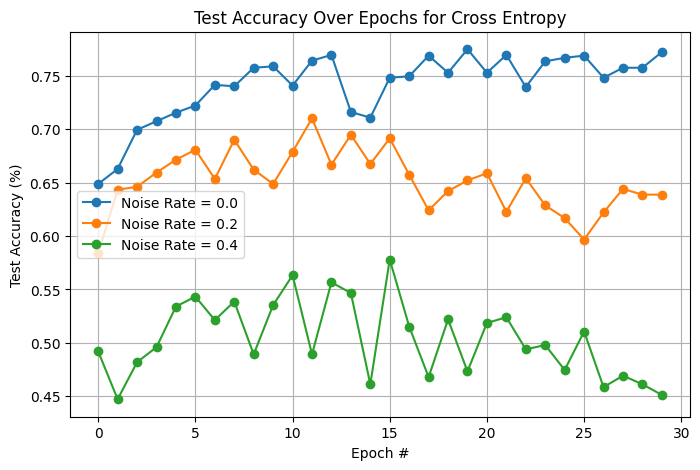

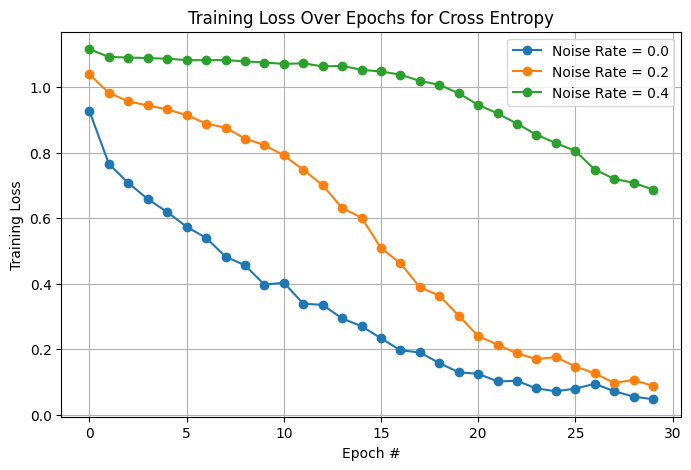

In [35]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for Cross Entropy")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for Cross Entropy")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


## Generalized Cross Entropy
Next we replace the loss function with GCE and rerun training with noise levels of $0.0,0.2,0.4$. We also experiment with the parameter $q = 0.2, 0.5, 0.7$.

In [36]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [3, 5, 6] # cat, dog, frog
noise_levels = [0.0, 0.2, 0.4]
q_val = 0.2
batch_size = 64
epochs = 30

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, q = {q_val} ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = GeneralizedCrossEntropy(q=q_val)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_gce_0.2_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, q = 0.2 ---
Epoch 1, Loss: 0.7546, Test Accuracy: 58.40%
Epoch 2, Loss: 0.6340, Test Accuracy: 67.27%
Epoch 3, Loss: 0.5695, Test Accuracy: 66.67%
Epoch 4, Loss: 0.5320, Test Accuracy: 72.87%
Epoch 5, Loss: 0.4827, Test Accuracy: 70.93%
Epoch 6, Loss: 0.4407, Test Accuracy: 72.53%
Epoch 7, Loss: 0.4155, Test Accuracy: 76.00%
Epoch 8, Loss: 0.3682, Test Accuracy: 74.20%
Epoch 9, Loss: 0.3319, Test Accuracy: 74.93%
Epoch 10, Loss: 0.3027, Test Accuracy: 72.67%
Epoch 11, Loss: 0.2809, Test Accuracy: 74.13%
Epoch 12, Loss: 0.2394, Test Accuracy: 75.20%
Epoch 13, Loss: 0.2093, Test Accuracy: 73.13%
Epoch 14, Loss: 0.1732, Test Accuracy: 77.00%
Epoch 15, Loss: 0.1609, Test Accuracy: 77.27%
Epoch 16, Loss: 0.1509, Test Accuracy: 75.87%
Epoch 17, Loss: 0.1417, Test Accuracy: 73.40%
Epoch 18, Loss: 0.0921, Test Accuracy: 76.47%
Epoch 19, Loss: 0.0921, Test Accuracy: 77.07%
Epoch 20, Loss: 0.0758, Test Accuracy: 77.93%
Epoch 21, Loss: 0.0644, Test Accuracy: 7

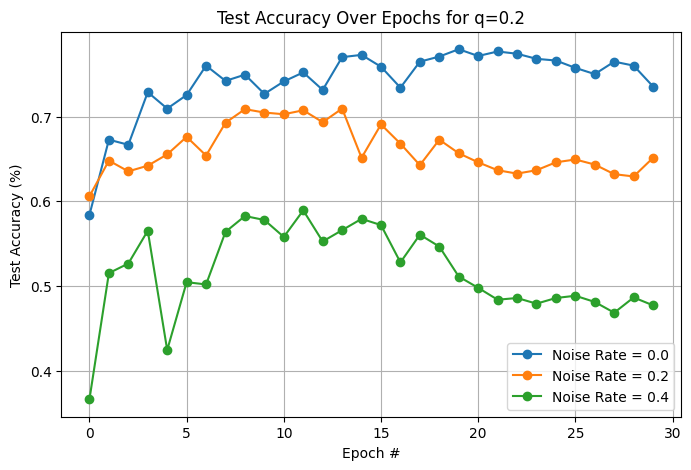

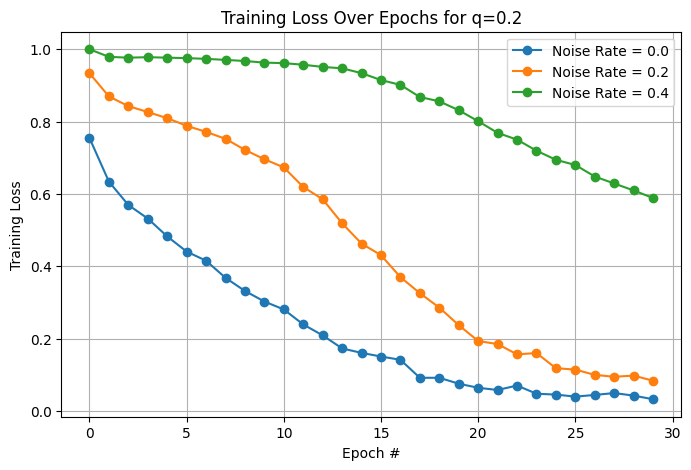

In [37]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for q=0.2")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for q=0.2")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


In [38]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [3, 5, 6] # cat, dog, frog
noise_levels = [0.0, 0.2, 0.4]
q_val = 0.5
batch_size = 64
epochs = 30

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, q = {q_val} ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = GeneralizedCrossEntropy(q=q_val)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_gce_0.2_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, q = 0.5 ---
Epoch 1, Loss: 0.6323, Test Accuracy: 64.93%
Epoch 2, Loss: 0.5348, Test Accuracy: 67.87%
Epoch 3, Loss: 0.4651, Test Accuracy: 69.87%
Epoch 4, Loss: 0.4221, Test Accuracy: 72.93%
Epoch 5, Loss: 0.3942, Test Accuracy: 67.80%
Epoch 6, Loss: 0.3612, Test Accuracy: 72.80%
Epoch 7, Loss: 0.3330, Test Accuracy: 62.20%
Epoch 8, Loss: 0.2974, Test Accuracy: 76.00%
Epoch 9, Loss: 0.2715, Test Accuracy: 74.33%
Epoch 10, Loss: 0.2490, Test Accuracy: 76.13%
Epoch 11, Loss: 0.2178, Test Accuracy: 74.67%
Epoch 12, Loss: 0.1990, Test Accuracy: 72.33%
Epoch 13, Loss: 0.1865, Test Accuracy: 69.47%
Epoch 14, Loss: 0.1670, Test Accuracy: 76.60%
Epoch 15, Loss: 0.1442, Test Accuracy: 76.60%
Epoch 16, Loss: 0.1258, Test Accuracy: 78.33%
Epoch 17, Loss: 0.1231, Test Accuracy: 78.20%
Epoch 18, Loss: 0.0986, Test Accuracy: 76.67%
Epoch 19, Loss: 0.1116, Test Accuracy: 76.73%
Epoch 20, Loss: 0.0910, Test Accuracy: 76.67%
Epoch 21, Loss: 0.0757, Test Accuracy: 7

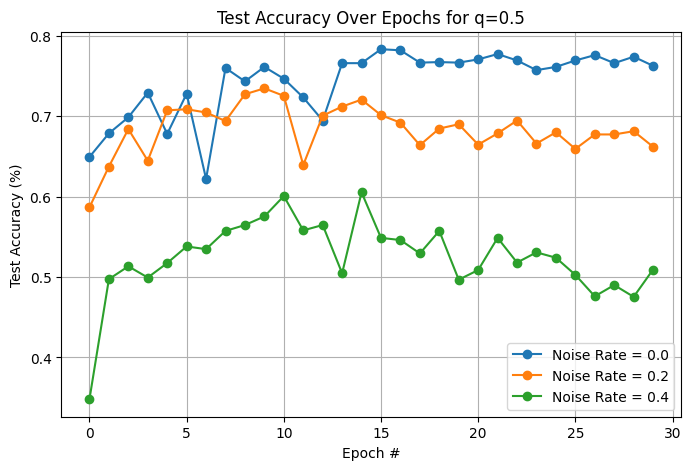

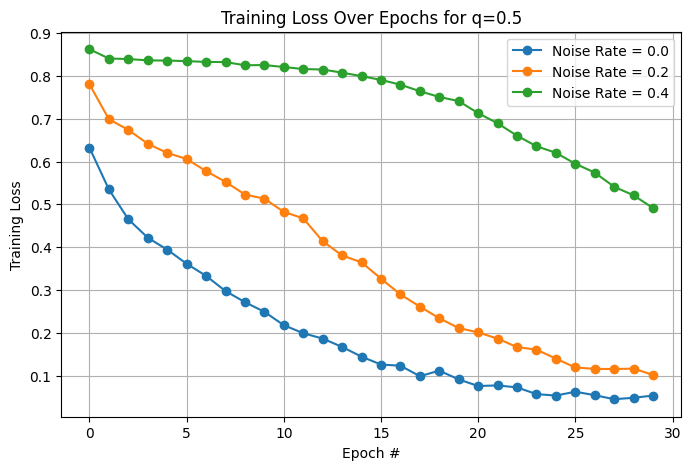

In [39]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for q=0.5")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for q=0.5")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


In [27]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [3, 5, 6] # cat, dog, frog
noise_levels = [0.0, 0.2, 0.4]
q_val = 0.7
batch_size = 64
epochs = 30

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, q = {q_val} ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = GeneralizedCrossEntropy(q=q_val)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_gce_0.2_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, q = 0.7 ---
Epoch 1, Loss: 0.6531, Test Accuracy: 55.60%
Epoch 2, Loss: 0.4949, Test Accuracy: 66.47%
Epoch 3, Loss: 0.4415, Test Accuracy: 67.20%
Epoch 4, Loss: 0.4083, Test Accuracy: 65.60%
Epoch 5, Loss: 0.3813, Test Accuracy: 70.07%
Epoch 6, Loss: 0.3550, Test Accuracy: 71.73%
Epoch 7, Loss: 0.3290, Test Accuracy: 71.80%
Epoch 8, Loss: 0.3121, Test Accuracy: 73.27%
Epoch 9, Loss: 0.2881, Test Accuracy: 72.67%
Epoch 10, Loss: 0.2767, Test Accuracy: 73.80%
Epoch 11, Loss: 0.2681, Test Accuracy: 66.47%
Epoch 12, Loss: 0.2451, Test Accuracy: 74.40%
Epoch 13, Loss: 0.2321, Test Accuracy: 71.53%
Epoch 14, Loss: 0.2265, Test Accuracy: 74.80%
Epoch 15, Loss: 0.2053, Test Accuracy: 76.67%
Epoch 16, Loss: 0.1886, Test Accuracy: 73.93%
Epoch 17, Loss: 0.1825, Test Accuracy: 71.60%
Epoch 18, Loss: 0.1613, Test Accuracy: 75.13%
Epoch 19, Loss: 0.1507, Test Accuracy: 75.73%
Epoch 20, Loss: 0.1385, Test Accuracy: 73.47%
Epoch 21, Loss: 0.1282, Test Accuracy: 7

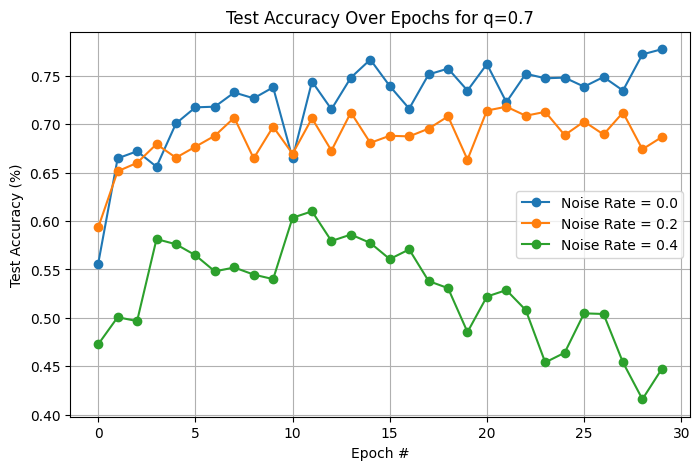

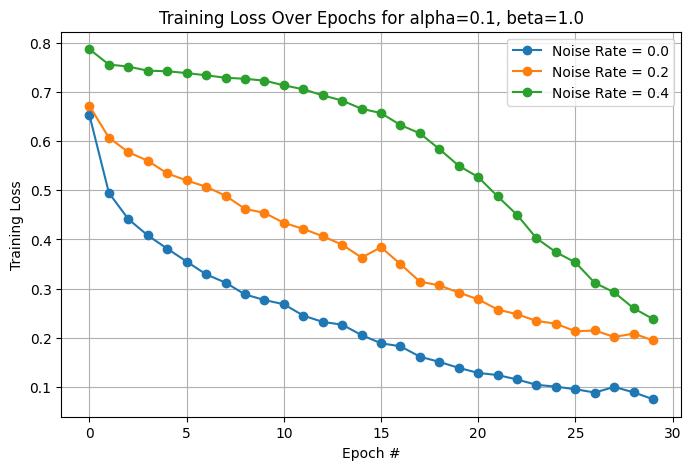

In [28]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for q=0.7")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for q=0.7")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


## Symmetric Cross Entropy
Next we rerun the experiments with loss function replaced with symmetric cross entropy. We use the same noise levels ($n = 0.0,0.2,0.4$). We set $(\alpha, \beta) = (0.1,1.0),(0.3,0.7), (0.05,1.5)$.

In [23]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [3, 5, 6] # cat, dog
noise_levels = [0.0, 0.2, 0.4]
batch_size = 64
epochs = 30

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, alpha= 0.1, beta=1.0 ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = SymmetricCrossEntropy(alpha=0.1, beta=1.0, num_classes=3)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_sce_0.1_1.0_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, alpha= 0.1, beta=1.0 ---
Epoch 1, Loss: 7.9791, Test Accuracy: 60.67%
Epoch 2, Loss: 6.4259, Test Accuracy: 60.20%
Epoch 3, Loss: 5.9409, Test Accuracy: 65.60%
Epoch 4, Loss: 5.7144, Test Accuracy: 66.60%
Epoch 5, Loss: 5.1651, Test Accuracy: 67.13%
Epoch 6, Loss: 4.8325, Test Accuracy: 65.53%
Epoch 7, Loss: 4.7320, Test Accuracy: 65.27%
Epoch 8, Loss: 4.4334, Test Accuracy: 68.40%
Epoch 9, Loss: 4.3889, Test Accuracy: 60.00%
Epoch 10, Loss: 4.1689, Test Accuracy: 70.00%
Epoch 11, Loss: 3.8636, Test Accuracy: 72.20%
Epoch 12, Loss: 3.7671, Test Accuracy: 71.13%
Epoch 13, Loss: 3.6232, Test Accuracy: 72.67%
Epoch 14, Loss: 3.2748, Test Accuracy: 70.87%
Epoch 15, Loss: 3.2853, Test Accuracy: 73.53%
Epoch 16, Loss: 3.0966, Test Accuracy: 74.47%
Epoch 17, Loss: 2.8648, Test Accuracy: 73.80%
Epoch 18, Loss: 2.8379, Test Accuracy: 73.47%
Epoch 19, Loss: 2.4637, Test Accuracy: 74.93%
Epoch 20, Loss: 2.4085, Test Accuracy: 74.80%
Epoch 21, Loss: 2.3090, Tes

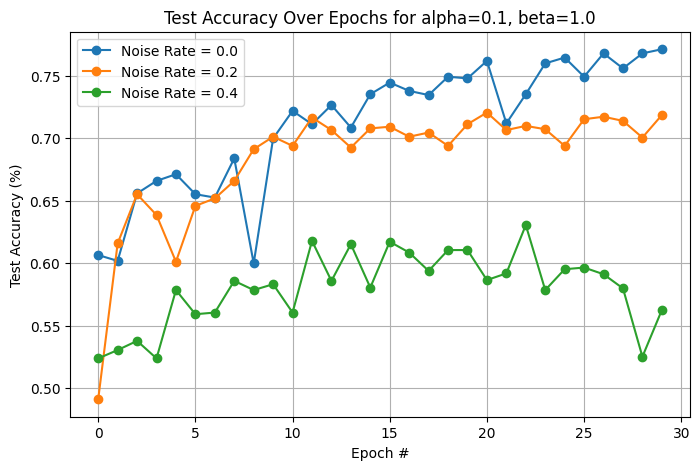

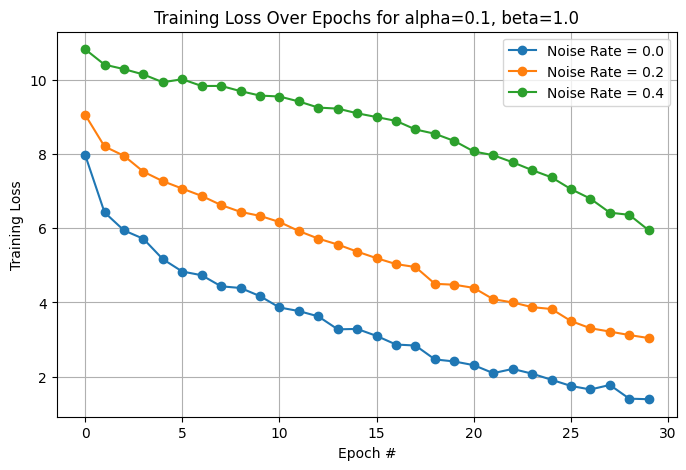

In [26]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for alpha=0.1, beta=1.0")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for alpha=0.1, beta=1.0")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


In [29]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [3, 5, 6] # cat, dog
noise_levels = [0.0, 0.2, 0.4]
batch_size = 64
epochs = 30

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, alpha= 0.3, beta=0.7 ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = SymmetricCrossEntropy(alpha=0.3, beta=0.7, num_classes=3)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_sce_0.3_0.7_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, alpha= 0.3, beta=0.7 ---
Epoch 1, Loss: 5.6935, Test Accuracy: 58.73%
Epoch 2, Loss: 4.5291, Test Accuracy: 66.80%
Epoch 3, Loss: 4.0849, Test Accuracy: 69.20%
Epoch 4, Loss: 3.9500, Test Accuracy: 68.80%
Epoch 5, Loss: 3.5498, Test Accuracy: 71.60%
Epoch 6, Loss: 3.3492, Test Accuracy: 72.27%
Epoch 7, Loss: 3.0606, Test Accuracy: 71.13%
Epoch 8, Loss: 2.8556, Test Accuracy: 74.00%
Epoch 9, Loss: 2.6684, Test Accuracy: 73.93%
Epoch 10, Loss: 2.5635, Test Accuracy: 74.33%
Epoch 11, Loss: 2.2799, Test Accuracy: 77.00%
Epoch 12, Loss: 2.2289, Test Accuracy: 74.27%
Epoch 13, Loss: 2.0242, Test Accuracy: 73.73%
Epoch 14, Loss: 1.8242, Test Accuracy: 72.87%
Epoch 15, Loss: 1.6779, Test Accuracy: 72.87%
Epoch 16, Loss: 1.5037, Test Accuracy: 76.13%
Epoch 17, Loss: 1.2105, Test Accuracy: 75.53%
Epoch 18, Loss: 1.2666, Test Accuracy: 75.07%
Epoch 19, Loss: 1.0234, Test Accuracy: 74.07%
Epoch 20, Loss: 1.0996, Test Accuracy: 76.00%
Epoch 21, Loss: 0.9788, Tes

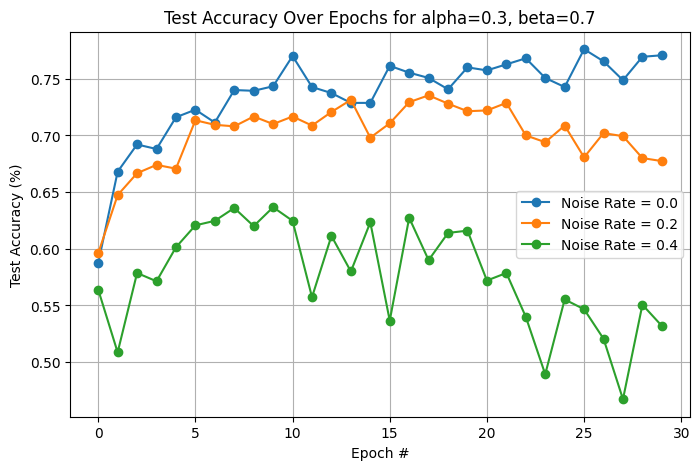

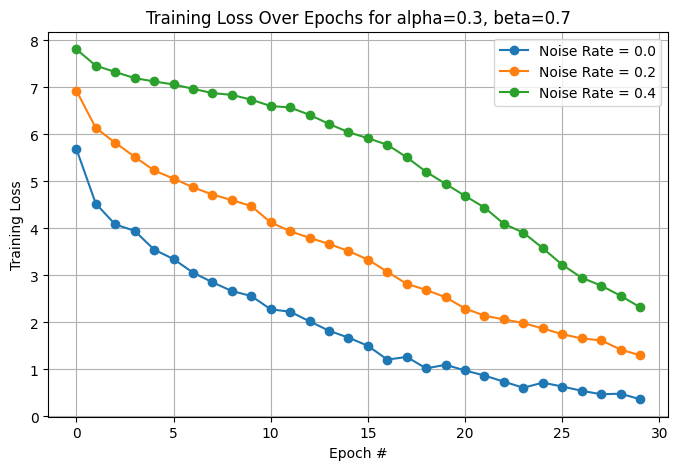

In [30]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for alpha=0.3, beta=0.7")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for alpha=0.3, beta=0.7")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


In [31]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [3, 5, 6] # cat, dog
noise_levels = [0.0, 0.2, 0.4]
batch_size = 64
epochs = 30

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, alpha= 0.05, beta=1.5 ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = SymmetricCrossEntropy(alpha=0.05, beta=1.5, num_classes=3)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_sce_0.05_1.5_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, alpha= 0.05, beta=1.5 ---
Epoch 1, Loss: 11.1959, Test Accuracy: 63.67%
Epoch 2, Loss: 9.6376, Test Accuracy: 61.47%
Epoch 3, Loss: 8.8321, Test Accuracy: 64.93%
Epoch 4, Loss: 8.5349, Test Accuracy: 63.40%
Epoch 5, Loss: 8.0763, Test Accuracy: 65.87%
Epoch 6, Loss: 7.3407, Test Accuracy: 67.93%
Epoch 7, Loss: 7.1614, Test Accuracy: 67.93%
Epoch 8, Loss: 6.9117, Test Accuracy: 66.60%
Epoch 9, Loss: 6.8392, Test Accuracy: 69.00%
Epoch 10, Loss: 6.3785, Test Accuracy: 70.60%
Epoch 11, Loss: 5.9407, Test Accuracy: 71.53%
Epoch 12, Loss: 6.0360, Test Accuracy: 61.93%
Epoch 13, Loss: 5.8527, Test Accuracy: 72.20%
Epoch 14, Loss: 5.5131, Test Accuracy: 73.47%
Epoch 15, Loss: 5.2326, Test Accuracy: 71.87%
Epoch 16, Loss: 5.0087, Test Accuracy: 74.33%
Epoch 17, Loss: 4.7498, Test Accuracy: 74.73%
Epoch 18, Loss: 4.5156, Test Accuracy: 70.80%
Epoch 19, Loss: 4.8621, Test Accuracy: 72.33%
Epoch 20, Loss: 4.3180, Test Accuracy: 75.00%
Epoch 21, Loss: 4.2906, T

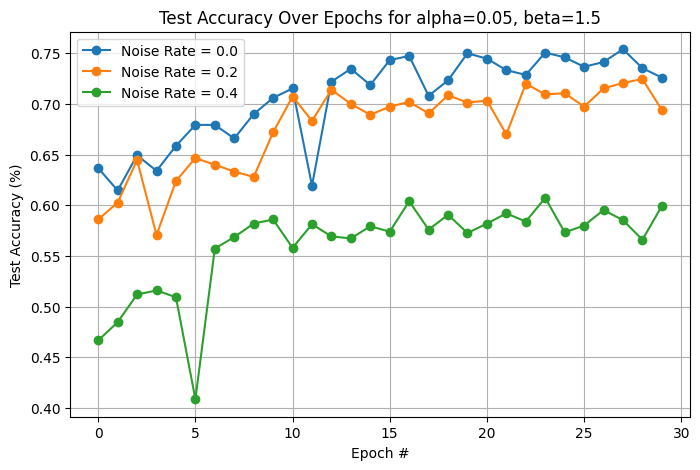

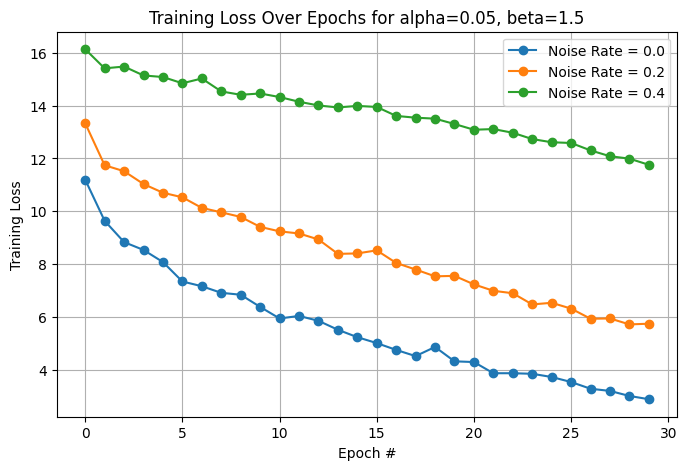

In [32]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for alpha=0.05, beta=1.5")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for alpha=0.05, beta=1.5")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


# Visually Different Class
For this next set of experiments, we will use the airplane, bird, truck classes in the CIFAR-10 dataset. We will keep all other variables the same; we decrease the number of training epochs from 30 to 20 since after 20 epochs, the training loss decreases but the validation accuracy starts decreasing. The goal is to compare how GCE and SCE perform when the classes are visually very different compared to the above set of experiments, where the classes were visually similar (cat vs dog).


## Cross Entropy

In [41]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [0, 2, 9] # airplace, bird, truck
noise_levels = [0.0, 0.2, 0.4]
batch_size = 64
epochs = 20

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate} ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss and model
    torch.save(model.state_dict(), f'model_weights_ce_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0 ---
Epoch 1, Loss: 0.6769, Test Accuracy: 75.67%
Epoch 2, Loss: 0.4949, Test Accuracy: 83.00%
Epoch 3, Loss: 0.4098, Test Accuracy: 80.67%
Epoch 4, Loss: 0.3459, Test Accuracy: 86.00%
Epoch 5, Loss: 0.3126, Test Accuracy: 83.00%
Epoch 6, Loss: 0.2724, Test Accuracy: 85.33%
Epoch 7, Loss: 0.2399, Test Accuracy: 84.67%
Epoch 8, Loss: 0.2272, Test Accuracy: 80.00%
Epoch 9, Loss: 0.2003, Test Accuracy: 86.33%
Epoch 10, Loss: 0.1618, Test Accuracy: 85.33%
Epoch 11, Loss: 0.1264, Test Accuracy: 86.67%
Epoch 12, Loss: 0.1407, Test Accuracy: 87.67%
Epoch 13, Loss: 0.1059, Test Accuracy: 89.33%
Epoch 14, Loss: 0.0842, Test Accuracy: 86.33%
Epoch 15, Loss: 0.0893, Test Accuracy: 87.33%
Epoch 16, Loss: 0.0805, Test Accuracy: 87.00%
Epoch 17, Loss: 0.0817, Test Accuracy: 88.33%
Epoch 18, Loss: 0.0484, Test Accuracy: 88.00%
Epoch 19, Loss: 0.0455, Test Accuracy: 87.33%
Epoch 20, Loss: 0.0499, Test Accuracy: 86.00%

--- Training with noise rate = 0.2 ---
Epoch 1, 

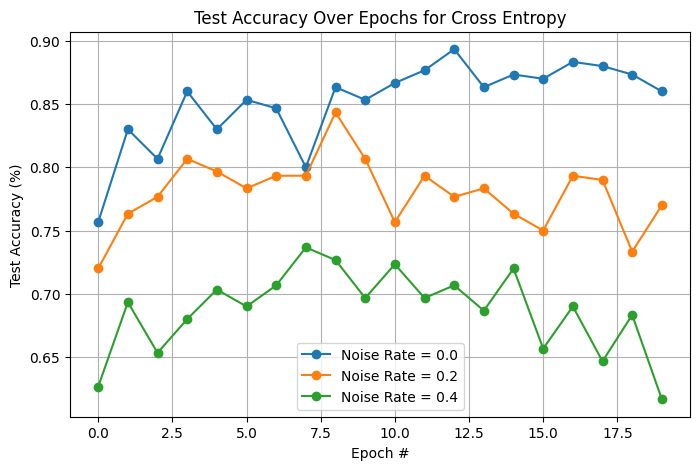

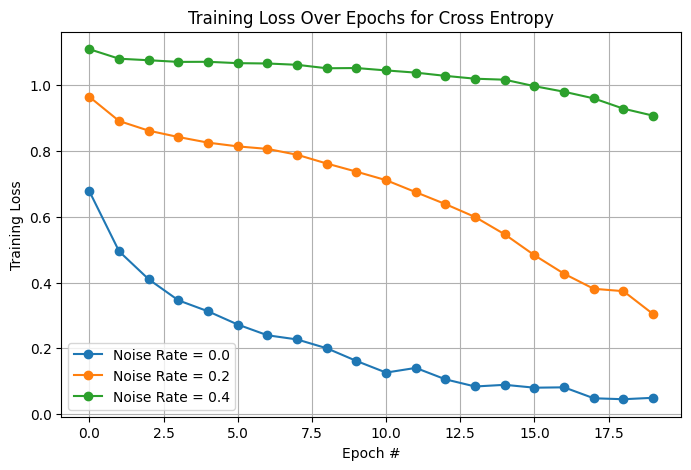

In [42]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for Cross Entropy")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for Cross Entropy")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


## Generalized Cross Entropy
Next we replace the loss function with GCE and rerun training with noise levels of $0.0,0.2,0.4$. We also experiment with the parameter $q = 0.2, 0.5, 0.8$.

In [44]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [0, 2, 9] # airplace, bird, truck
noise_levels = [0.0, 0.2, 0.4]
q_val = 0.2
batch_size = 64
epochs = 20

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, q = {q_val} ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = GeneralizedCrossEntropy(q=q_val)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_gce_0.2_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, q = 0.2 ---
Epoch 1, Loss: 0.5599, Test Accuracy: 78.80%
Epoch 2, Loss: 0.3998, Test Accuracy: 80.93%
Epoch 3, Loss: 0.3442, Test Accuracy: 82.87%
Epoch 4, Loss: 0.2901, Test Accuracy: 84.53%
Epoch 5, Loss: 0.2587, Test Accuracy: 86.13%
Epoch 6, Loss: 0.2389, Test Accuracy: 86.07%
Epoch 7, Loss: 0.2064, Test Accuracy: 82.13%
Epoch 8, Loss: 0.1967, Test Accuracy: 83.93%
Epoch 9, Loss: 0.1519, Test Accuracy: 87.13%
Epoch 10, Loss: 0.1662, Test Accuracy: 84.27%
Epoch 11, Loss: 0.1227, Test Accuracy: 85.73%
Epoch 12, Loss: 0.1172, Test Accuracy: 83.00%
Epoch 13, Loss: 0.1093, Test Accuracy: 86.73%
Epoch 14, Loss: 0.0821, Test Accuracy: 86.53%
Epoch 15, Loss: 0.0737, Test Accuracy: 85.67%
Epoch 16, Loss: 0.0539, Test Accuracy: 86.73%
Epoch 17, Loss: 0.0690, Test Accuracy: 87.80%
Epoch 18, Loss: 0.0477, Test Accuracy: 86.47%
Epoch 19, Loss: 0.0397, Test Accuracy: 87.67%
Epoch 20, Loss: 0.0434, Test Accuracy: 87.67%

--- Training with noise rate = 0.2, q =

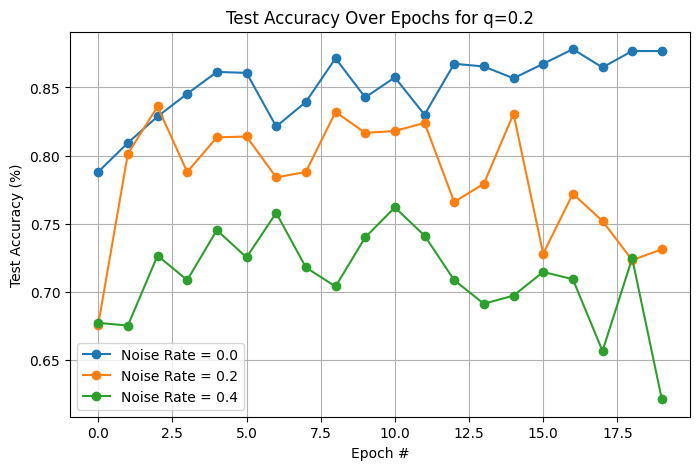

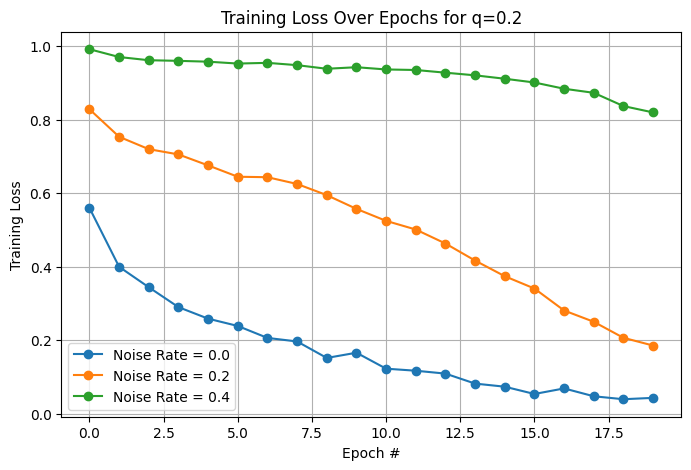

In [45]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for q=0.2")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for q=0.2")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


In [46]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [0, 2, 9] # airplace, bird, truck
noise_levels = [0.0, 0.2, 0.4]
q_val = 0.5
batch_size = 64
epochs = 20

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, q = {q_val} ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = GeneralizedCrossEntropy(q=q_val)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_gce_0.2_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, q = 0.5 ---
Epoch 1, Loss: 0.4273, Test Accuracy: 73.53%
Epoch 2, Loss: 0.3080, Test Accuracy: 80.53%
Epoch 3, Loss: 0.2836, Test Accuracy: 83.27%
Epoch 4, Loss: 0.2530, Test Accuracy: 83.87%
Epoch 5, Loss: 0.2214, Test Accuracy: 84.47%
Epoch 6, Loss: 0.2027, Test Accuracy: 82.80%
Epoch 7, Loss: 0.1816, Test Accuracy: 84.93%
Epoch 8, Loss: 0.1776, Test Accuracy: 85.07%
Epoch 9, Loss: 0.1582, Test Accuracy: 81.07%
Epoch 10, Loss: 0.1423, Test Accuracy: 85.20%
Epoch 11, Loss: 0.1339, Test Accuracy: 84.93%
Epoch 12, Loss: 0.1161, Test Accuracy: 87.13%
Epoch 13, Loss: 0.1071, Test Accuracy: 86.40%
Epoch 14, Loss: 0.1011, Test Accuracy: 86.07%
Epoch 15, Loss: 0.0929, Test Accuracy: 86.60%
Epoch 16, Loss: 0.0868, Test Accuracy: 85.80%
Epoch 17, Loss: 0.0781, Test Accuracy: 85.53%
Epoch 18, Loss: 0.0851, Test Accuracy: 86.47%
Epoch 19, Loss: 0.0601, Test Accuracy: 87.73%
Epoch 20, Loss: 0.0608, Test Accuracy: 87.07%

--- Training with noise rate = 0.2, q =

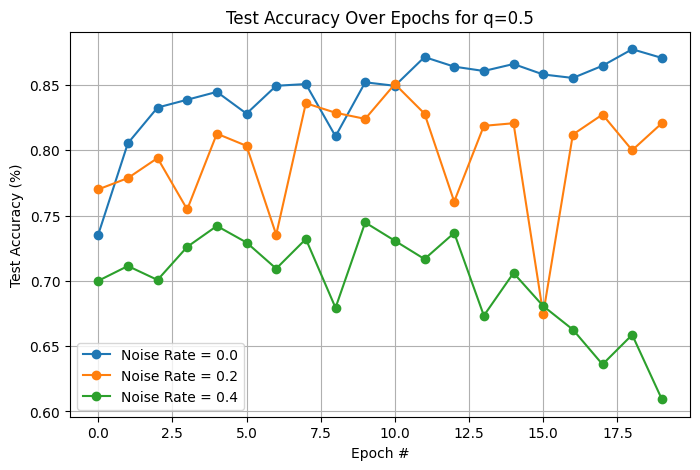

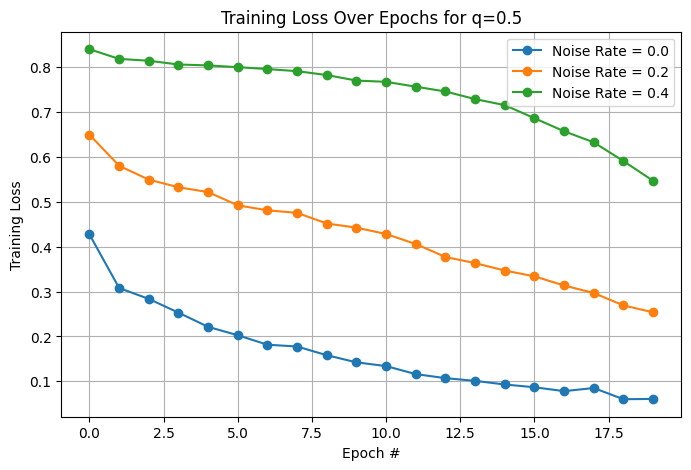

In [47]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for q=0.5")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for q=0.5")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


In [48]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [0, 2, 9] # airplace, bird, truck
noise_levels = [0.0, 0.2, 0.4]
q_val = 0.7
batch_size = 64
epochs = 20

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, q = {q_val} ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = GeneralizedCrossEntropy(q=q_val)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_gce_0.2_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, q = 0.7 ---
Epoch 1, Loss: 0.3746, Test Accuracy: 75.27%
Epoch 2, Loss: 0.2815, Test Accuracy: 80.33%
Epoch 3, Loss: 0.2313, Test Accuracy: 81.07%
Epoch 4, Loss: 0.2225, Test Accuracy: 80.93%
Epoch 5, Loss: 0.2126, Test Accuracy: 83.47%
Epoch 6, Loss: 0.1917, Test Accuracy: 83.87%
Epoch 7, Loss: 0.1815, Test Accuracy: 78.27%
Epoch 8, Loss: 0.1605, Test Accuracy: 84.33%
Epoch 9, Loss: 0.1563, Test Accuracy: 82.53%
Epoch 10, Loss: 0.1498, Test Accuracy: 84.13%
Epoch 11, Loss: 0.1384, Test Accuracy: 85.27%
Epoch 12, Loss: 0.1265, Test Accuracy: 84.20%
Epoch 13, Loss: 0.1394, Test Accuracy: 86.80%
Epoch 14, Loss: 0.1188, Test Accuracy: 85.40%
Epoch 15, Loss: 0.1189, Test Accuracy: 86.27%
Epoch 16, Loss: 0.1088, Test Accuracy: 84.67%
Epoch 17, Loss: 0.1053, Test Accuracy: 86.20%
Epoch 18, Loss: 0.1072, Test Accuracy: 87.07%
Epoch 19, Loss: 0.0948, Test Accuracy: 85.33%
Epoch 20, Loss: 0.0889, Test Accuracy: 87.20%

--- Training with noise rate = 0.2, q =

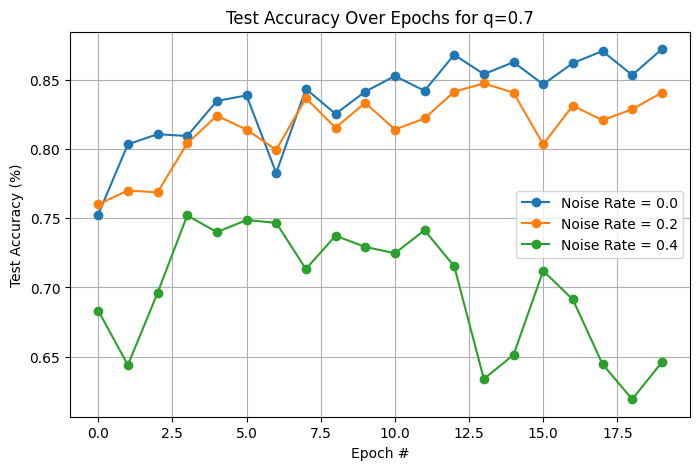

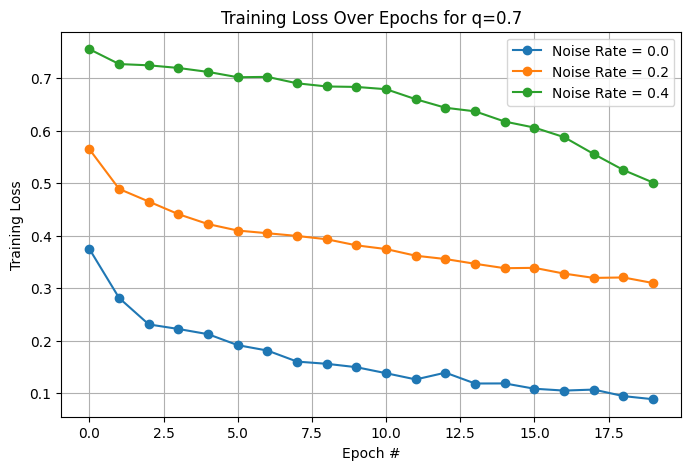

In [49]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for q=0.7")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for q=0.7")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


## Symmetric Cross Entropy
Next we rerun the experiments with loss function replaced with symmetric cross entropy. We use the same noise levels ($n = 0.0,0.2,0.4$). We set $(\alpha, \beta) = (0.1,1.0),(0.3,0.7), (0.05,1.5)$.

In [50]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [0, 2, 9] # airplace, bird, truck
noise_levels = [0.0, 0.2, 0.4]
batch_size = 64
epochs = 20

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, alpha= 0.1, beta=1.0 ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = SymmetricCrossEntropy(alpha=0.1, beta=1.0, num_classes=3)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_sce_0.1_1.0_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, alpha= 0.1, beta=1.0 ---
Epoch 1, Loss: 4.9066, Test Accuracy: 77.47%
Epoch 2, Loss: 3.6567, Test Accuracy: 78.80%
Epoch 3, Loss: 3.2676, Test Accuracy: 76.93%
Epoch 4, Loss: 3.1154, Test Accuracy: 78.67%
Epoch 5, Loss: 2.9266, Test Accuracy: 81.73%
Epoch 6, Loss: 2.7690, Test Accuracy: 80.07%
Epoch 7, Loss: 2.6196, Test Accuracy: 83.73%
Epoch 8, Loss: 2.3977, Test Accuracy: 84.00%
Epoch 9, Loss: 2.3416, Test Accuracy: 85.00%
Epoch 10, Loss: 2.1280, Test Accuracy: 85.00%
Epoch 11, Loss: 1.9630, Test Accuracy: 84.73%
Epoch 12, Loss: 2.0091, Test Accuracy: 84.67%
Epoch 13, Loss: 1.8240, Test Accuracy: 81.73%
Epoch 14, Loss: 1.7471, Test Accuracy: 83.87%
Epoch 15, Loss: 1.7935, Test Accuracy: 86.13%
Epoch 16, Loss: 1.5406, Test Accuracy: 85.67%
Epoch 17, Loss: 1.4652, Test Accuracy: 86.00%
Epoch 18, Loss: 1.4526, Test Accuracy: 86.80%
Epoch 19, Loss: 1.4593, Test Accuracy: 84.87%
Epoch 20, Loss: 1.3370, Test Accuracy: 85.93%

--- Training with noise ra

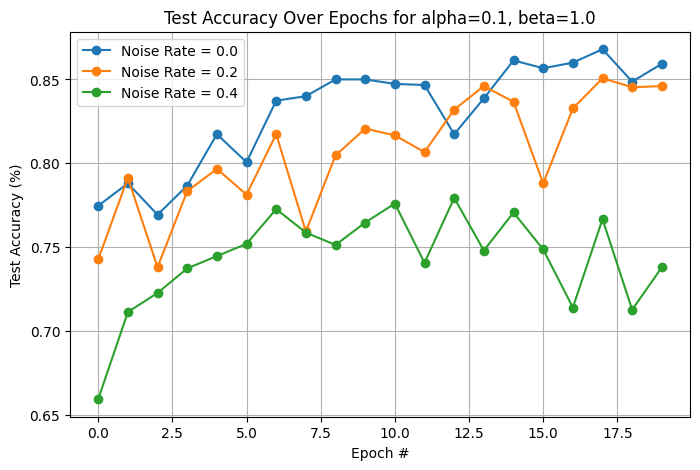

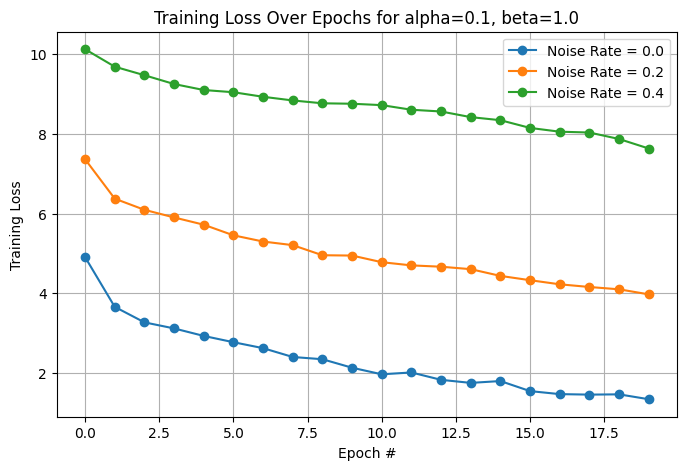

In [51]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for alpha=0.1, beta=1.0")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for alpha=0.1, beta=1.0")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


In [52]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [0, 2, 9] # airplace, bird, truck
noise_levels = [0.0, 0.2, 0.4]
batch_size = 64
epochs = 20

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, alpha= 0.3, beta=0.7 ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = SymmetricCrossEntropy(alpha=0.3, beta=0.7, num_classes=3)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_sce_0.3_0.7_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, alpha= 0.3, beta=0.7 ---
Epoch 1, Loss: 3.7604, Test Accuracy: 69.40%
Epoch 2, Loss: 2.7207, Test Accuracy: 78.53%
Epoch 3, Loss: 2.3668, Test Accuracy: 81.27%
Epoch 4, Loss: 2.1286, Test Accuracy: 81.93%
Epoch 5, Loss: 2.0304, Test Accuracy: 81.27%
Epoch 6, Loss: 1.9104, Test Accuracy: 82.47%
Epoch 7, Loss: 1.7762, Test Accuracy: 82.40%
Epoch 8, Loss: 1.6316, Test Accuracy: 85.80%
Epoch 9, Loss: 1.5877, Test Accuracy: 85.00%
Epoch 10, Loss: 1.4833, Test Accuracy: 84.33%
Epoch 11, Loss: 1.2446, Test Accuracy: 85.47%
Epoch 12, Loss: 1.3164, Test Accuracy: 87.67%
Epoch 13, Loss: 1.0917, Test Accuracy: 86.93%
Epoch 14, Loss: 1.0602, Test Accuracy: 86.80%
Epoch 15, Loss: 0.9733, Test Accuracy: 86.33%
Epoch 16, Loss: 0.9332, Test Accuracy: 85.13%
Epoch 17, Loss: 0.8875, Test Accuracy: 85.27%
Epoch 18, Loss: 0.8698, Test Accuracy: 88.13%
Epoch 19, Loss: 0.8016, Test Accuracy: 87.27%
Epoch 20, Loss: 0.6790, Test Accuracy: 81.93%

--- Training with noise ra

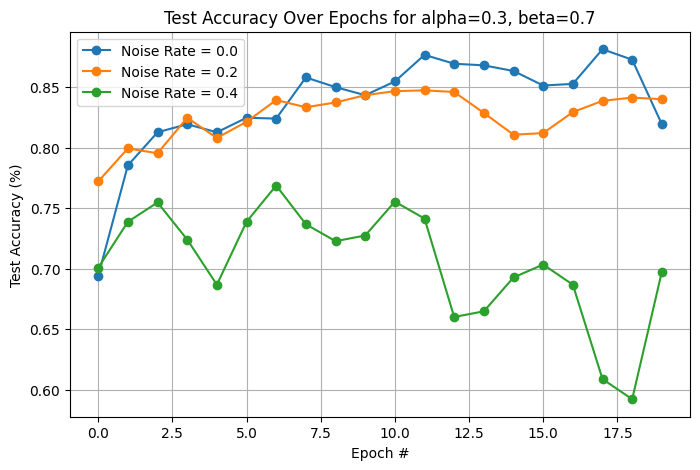

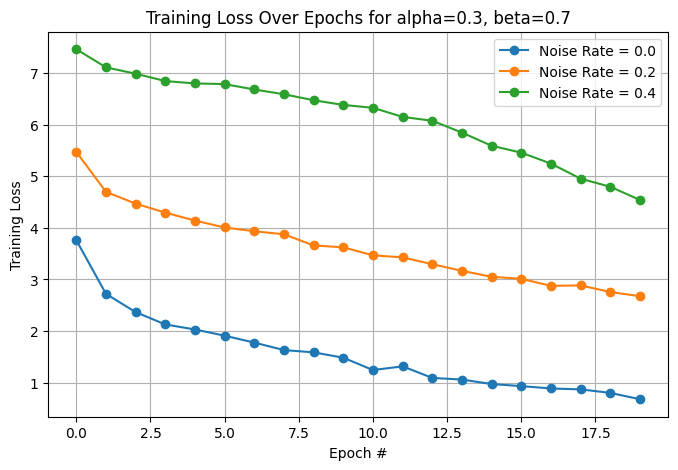

In [53]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for alpha=0.3, beta=0.7")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for alpha=0.3, beta=0.7")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


In [54]:
# Initialize constants
num_train_samples = 2000
num_test_samples = 500
classes = [0, 2, 9] # airplace, bird, truck
noise_levels = [0.0, 0.2, 0.4]
batch_size = 64
epochs = 20

accuracies = []
all_train_losses = []

# Load training and testing data
train_data, test_data = get_class_subset(classes, num_train_samples, num_test_samples)

for noise_rate in noise_levels:
    print(f"\n--- Training with noise rate = {noise_rate}, alpha= 0.05, beta=1.5 ---")
    # add noise
    noisy_train_data = add_noise(train_data, len(classes), noise_rate=noise_rate)

    # Create dataloader
    train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # Train and Test
    model = CNN(num_classes=3)
    loss_fn = SymmetricCrossEntropy(alpha=0.05, beta=1.5, num_classes=3)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    model, train_losses, test_accuracy = train(model, optimizer, loss_fn, train_loader, test_loader, epochs)
    # save test accuracies and training loss
    torch.save(model.state_dict(), f'model_weights_sce_0.05_1.5_{noise_rate}.pth')
    accuracies.append(test_accuracy)
    all_train_losses.append(train_losses)


--- Training with noise rate = 0.0, alpha= 0.05, beta=1.5 ---
Epoch 1, Loss: 7.2650, Test Accuracy: 74.67%
Epoch 2, Loss: 5.7832, Test Accuracy: 74.73%
Epoch 3, Loss: 5.2071, Test Accuracy: 79.87%
Epoch 4, Loss: 4.4467, Test Accuracy: 81.40%
Epoch 5, Loss: 4.5622, Test Accuracy: 78.53%
Epoch 6, Loss: 4.3502, Test Accuracy: 78.80%
Epoch 7, Loss: 4.0645, Test Accuracy: 81.80%
Epoch 8, Loss: 3.8359, Test Accuracy: 83.07%
Epoch 9, Loss: 3.7503, Test Accuracy: 84.20%
Epoch 10, Loss: 3.5163, Test Accuracy: 84.13%
Epoch 11, Loss: 3.3127, Test Accuracy: 82.60%
Epoch 12, Loss: 3.1090, Test Accuracy: 83.60%
Epoch 13, Loss: 3.2447, Test Accuracy: 83.20%
Epoch 14, Loss: 2.8688, Test Accuracy: 82.67%
Epoch 15, Loss: 2.9520, Test Accuracy: 85.67%
Epoch 16, Loss: 2.8190, Test Accuracy: 85.80%
Epoch 17, Loss: 2.9576, Test Accuracy: 83.60%
Epoch 18, Loss: 2.6289, Test Accuracy: 86.13%
Epoch 19, Loss: 2.6129, Test Accuracy: 85.47%
Epoch 20, Loss: 2.5304, Test Accuracy: 85.07%

--- Training with noise r

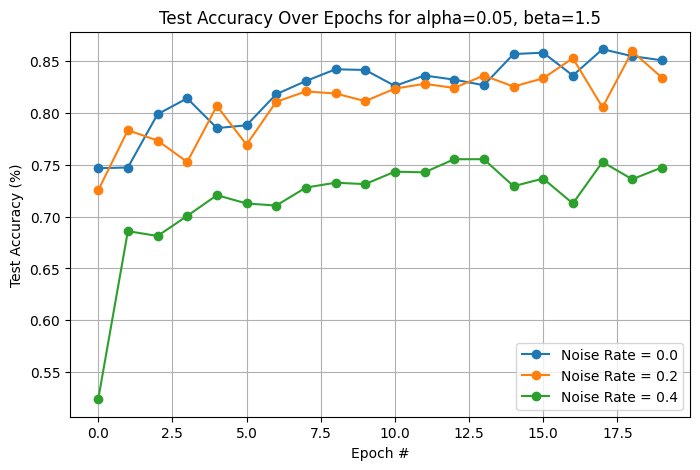

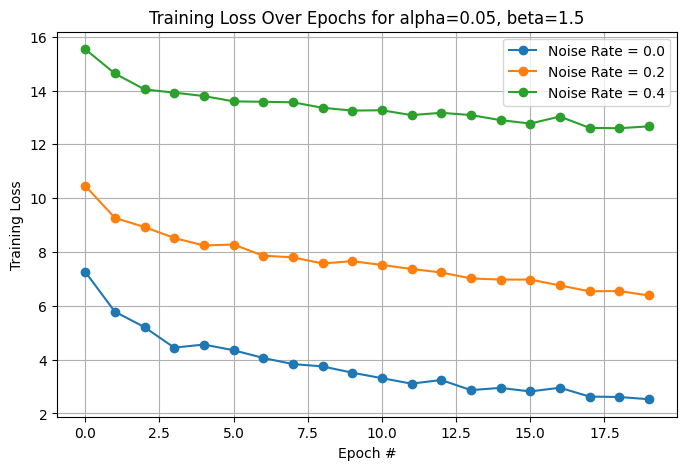

In [55]:
# Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), accuracies[0], marker='o')
plt.plot(range(epochs), accuracies[1], marker='o')
plt.plot(range(epochs), accuracies[2], marker='o')
plt.title("Test Accuracy Over Epochs for alpha=0.05, beta=1.5")
plt.xlabel("Epoch #")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), all_train_losses[0], marker='o')
plt.plot(range(epochs), all_train_losses[1], marker='o')
plt.plot(range(epochs), all_train_losses[2], marker='o')
plt.title("Training Loss Over Epochs for alpha=0.05, beta=1.5")
plt.xlabel("Epoch #")
plt.ylabel("Training Loss")
plt.legend(["Noise Rate = 0.0", "Noise Rate = 0.2", "Noise Rate = 0.4"])
plt.grid(True)
plt.show()


# Results
The GCE and SCE were shown to give small improvements for noise levels at $n = 0.2, 0.4$. GCE performed better at $q=0.7$ for the cat/dog/frog data. For the plane/bird/truck data, GCE performed better at $q=0.5$. Tuning $q$ may depend on the dataset. The improvement was most significant for higher noise.

SCE performed best at $\alpha=0.1, \beta=1.0$ for the cat/dog/frog data. For plane/bird/truck data it performed best at $\alpha=0.3, \beta=0.7$. So again the parameters may need to be tuned to the dataset.

There was also a slight decrease in accuracy when using the GCE and SCE compared to cross entropy for the no noise case. This makes sense since we want to penalize confident wrong predictions heavily when we can be certain about the data's labels.

The trends were similar between the cat/dog/frog data and plane/bird/truck data. Both demonstrated more improvement when using GCE and SCE for higher noise. The plane/bird/truck data experienced a slightly larger decrease in accuracy for the no noise case when using GCE and SCE compared to cross entropy.

# Further Exploration
An extension to this project would be to apply the GCE and SCE loss function to larger models like ResNet. Due to limits of computational resources, I was not able to perform those here. The deeper layers of ResNet could be frozen. Additional layer would then be added on top tune the model towards the given dataset.

Additional avenues of exploration include testing GCE and SCE on training sets with more than 3 classes. Do the effects translate for 10 classes or 100 classes? Classes with similar features (cat vs dog) may behave differently from classes with very different features (cat vs airplane). This combined with an increase of class may behave very differently from the experiments performed above. Are the effects of our robust loss functions magnified with more classes? Does it perform better or worse when many of the classes have an overlap of features?

# Conclusion
Robust cross-entropy methods like generalized cross entropy and symmetric cross entropy are able to handle noisy labels better than traditional cross entropy classifer loss. They work well in cases when the classes differ visually as well as when they share similar features.